# Instance Segmentation with Mask R-CNN with GPU support

*by Georgios K. Ouzounis, June 22nd, 2021*

In this notebook we will experiment with instance segmentation in still images using the Mask R-CNN model, trained on GPU.

This is a slightly altered version of the original notebook posted by [Matterport, Inc](https://matterport.com/) that can be [found here](https://github.com/matterport/Mask_RCNN).

For each test image, the output set of predictions includes bounding boxes, labels and instance masks that are overlayed on the input. 

## Install packages

Mask R-CNN has certain outdated dependencies and we need to re-install some packages.

The first is Tensorflow, which in the case of Google Colab is available in different versions. Using TensorFlow 1.x requires downgrading h5py too. This, after installation, will prompt for a restart of the Runtime. Click the button to confirm and do not re-execute the ```pip install```.

You may ignore the different dependency erros as the packages they refer to are not relevant for this exercise.   

In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9MB 6.5MB/s 
     |████████████████████████████████| 15.7MB 184kB/s 
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.21.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Found ex

If you wish to review the configuration of the newly installed HDF5 execute the command below.

In [ ]:
!h5cc -showconfig

## Clone the repo from GitHub

Get a local copy of the Matterport repo

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 33.06 MiB/s, done.
Resolving deltas: 100% (562/562), done.


## Import the libraries

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import sys
import random
import math
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

TensorFlow 1.x selected.


# Prepare Model

In [ ]:
import os 
os.chdir('Mask_RCNN/samples')

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


# Create & configure an Inference Object

In [ ]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
CLASS_NAMES = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Model inference and visualization

### Load a test image

option 1: get a test image from the author's github account

<img src="https://github.com/georgiosouzounis/instance-segmentation-mask-rcnn/raw/main/data/manhattan.jpg" width="400"/>

In [ ]:
!wget https://github.com/georgiosouzounis/instance-segmentation-mask-rcnn/raw/main/data/manhattan.jpg -O /content/test_image.jpg
test_img_path = "/content/test_image.jpg"

--2021-07-07 12:53:55--  https://github.com/georgiosouzounis/instance-segmentation-mask-rcnn/raw/main/data/manhattan.jpg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/georgiosouzounis/instance-segmentation-mask-rcnn/main/data/manhattan.jpg [following]
--2021-07-07 12:53:55--  https://raw.githubusercontent.com/georgiosouzounis/instance-segmentation-mask-rcnn/main/data/manhattan.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 642726 (628K) [image/jpeg]
Saving to: ‘/content/test_image.jpg’

/content/test_image 100%[===================>] 627.66K  --.-KB/s    in 0.04s   

2021-07-07 12:53:56 (1

option 2: get an image for the test set of the Matterport repo:

<img src="https://github.com/matterport/Mask_RCNN/raw/master/images/8829708882_48f263491e_z.jpg" width="400"/>

In [ ]:
test_img_path = "/content/Mask_RCNN/images/8829708882_48f263491e_z.jpg"

option 3: use **wget** to download an image from the web or mount your Google Drive and copy one locally.

### Read the image

In [ ]:
# read the image
image = cv2.imread(test_img_path)
# convert the BGR order to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Model inference and result visualization

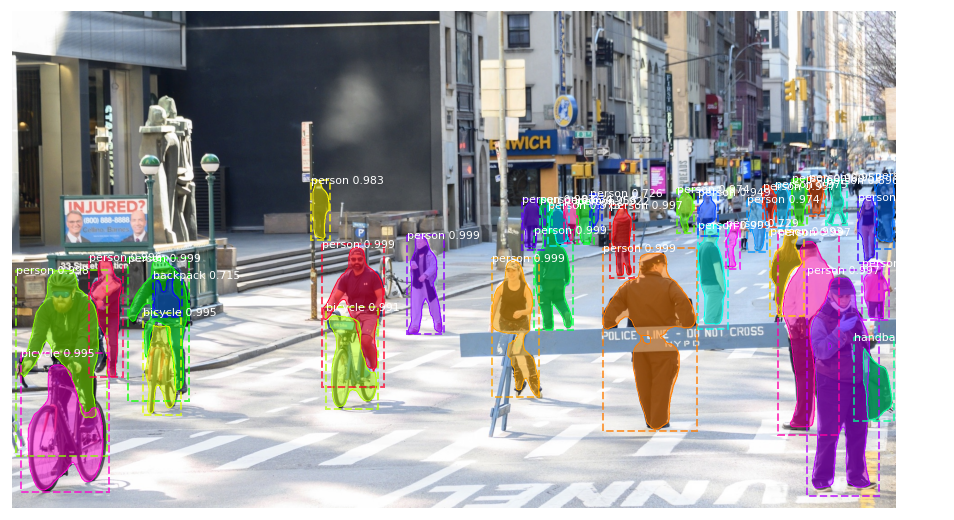

In [ ]:
tmp = image.copy()

# model inference
results = model.detect([image], verbose=0)

# result visualization
r = results[0]
visualize.display_instances(tmp, r['rois'], r['masks'], r['class_ids'], 
                            CLASS_NAMES, r['scores'])

## Custom visualization with score filtering

In this section we will use a custom coloring scheme together with detection score filters. Note that by using a custom color per class as opposed to instance, we change the output type from **instance segmentation** to **semantic segmentation**. 

Set the score threshold

In [ ]:
score_threshold = 0.66    #@param {type:"slider", min:0, max:1, step:0.01}

Define random class colors. The method comes from the Matterport repo and ensures that generated colors are visually distinct.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4e/HSV_color_solid_cylinder.png" width="400"/>

In [ ]:
import colorsys

# create a Hue-Saturation-Value list with saturation and value preset to 1
# changes in hue are essentially changes in color.     
hsv = [(i / len(CLASS_NAMES), 1, 1.0) for i in range(len(CLASS_NAMES))]

# in what follows:
# - the lambda function is the converter of an HSV triplet to RGB;
# - the map (i.e. r = map(func, seq)) applies this function to the sequence hsv;
# - in Python 3, map() returns an iterator. To get the results in a list we use 
#   the list() function 
CLASS_COLORS = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))

# shuffle the generated colors so that there is no correlation with the class IDs
random.seed(42)
random.shuffle(CLASS_COLORS)

Imprint the masks of the detected objects into the image  

In [ ]:
from google.colab.patches import cv2_imshow

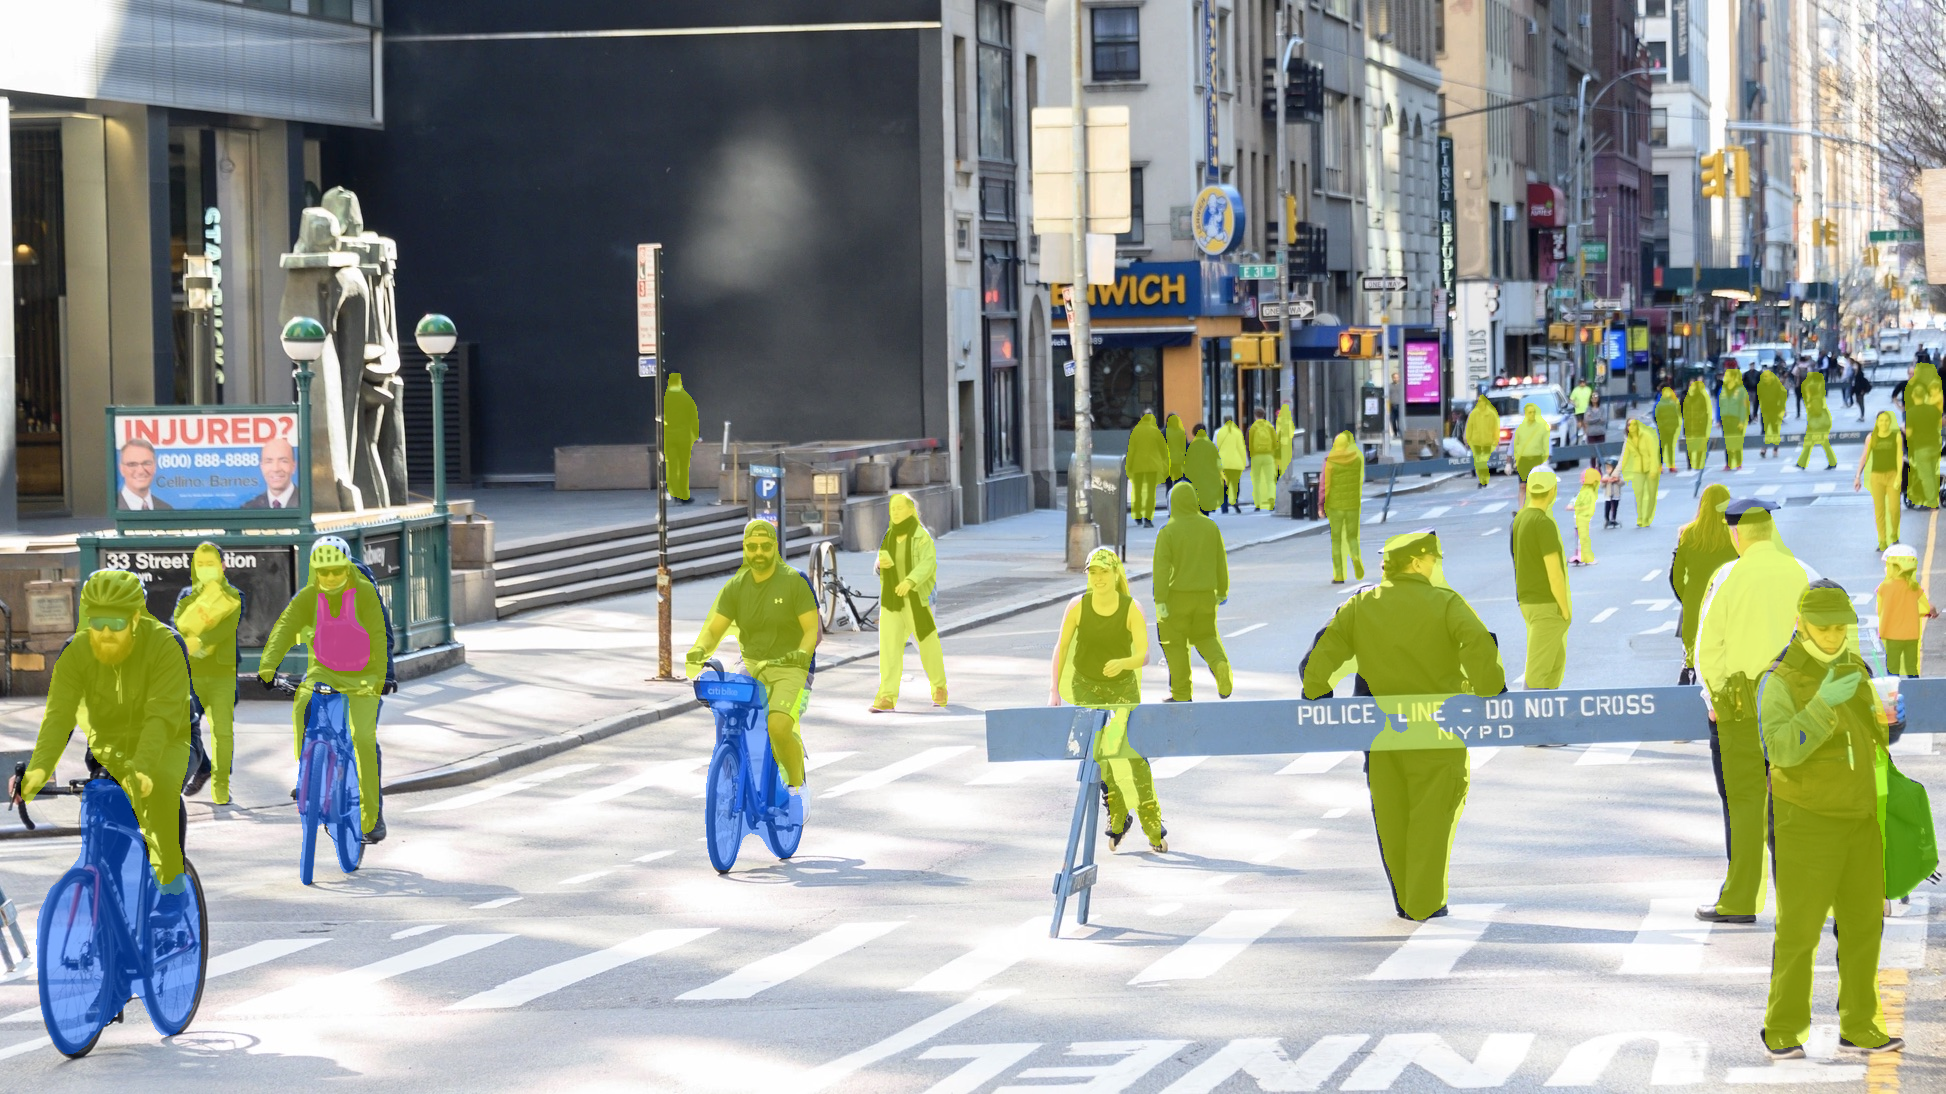

In [ ]:
output = image.copy()
output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)

# loop through the detected objects
for i in range(0, r["rois"].shape[0]):
  score = r["scores"][i]
  # filter the detections based on score
  if score > score_threshold:
    # get the class ID for the current detection
    classID = r["class_ids"][i]
    # get the mask for teh current detection 
    mask = r["masks"][:, :, i]
    # get the color assigned to the detected class
    color = CLASS_COLORS[classID][::-1]
    # imprint the mask in the image 
    output = visualize.apply_mask(output, mask, color, alpha=0.5)
# display the result
cv2_imshow(output)

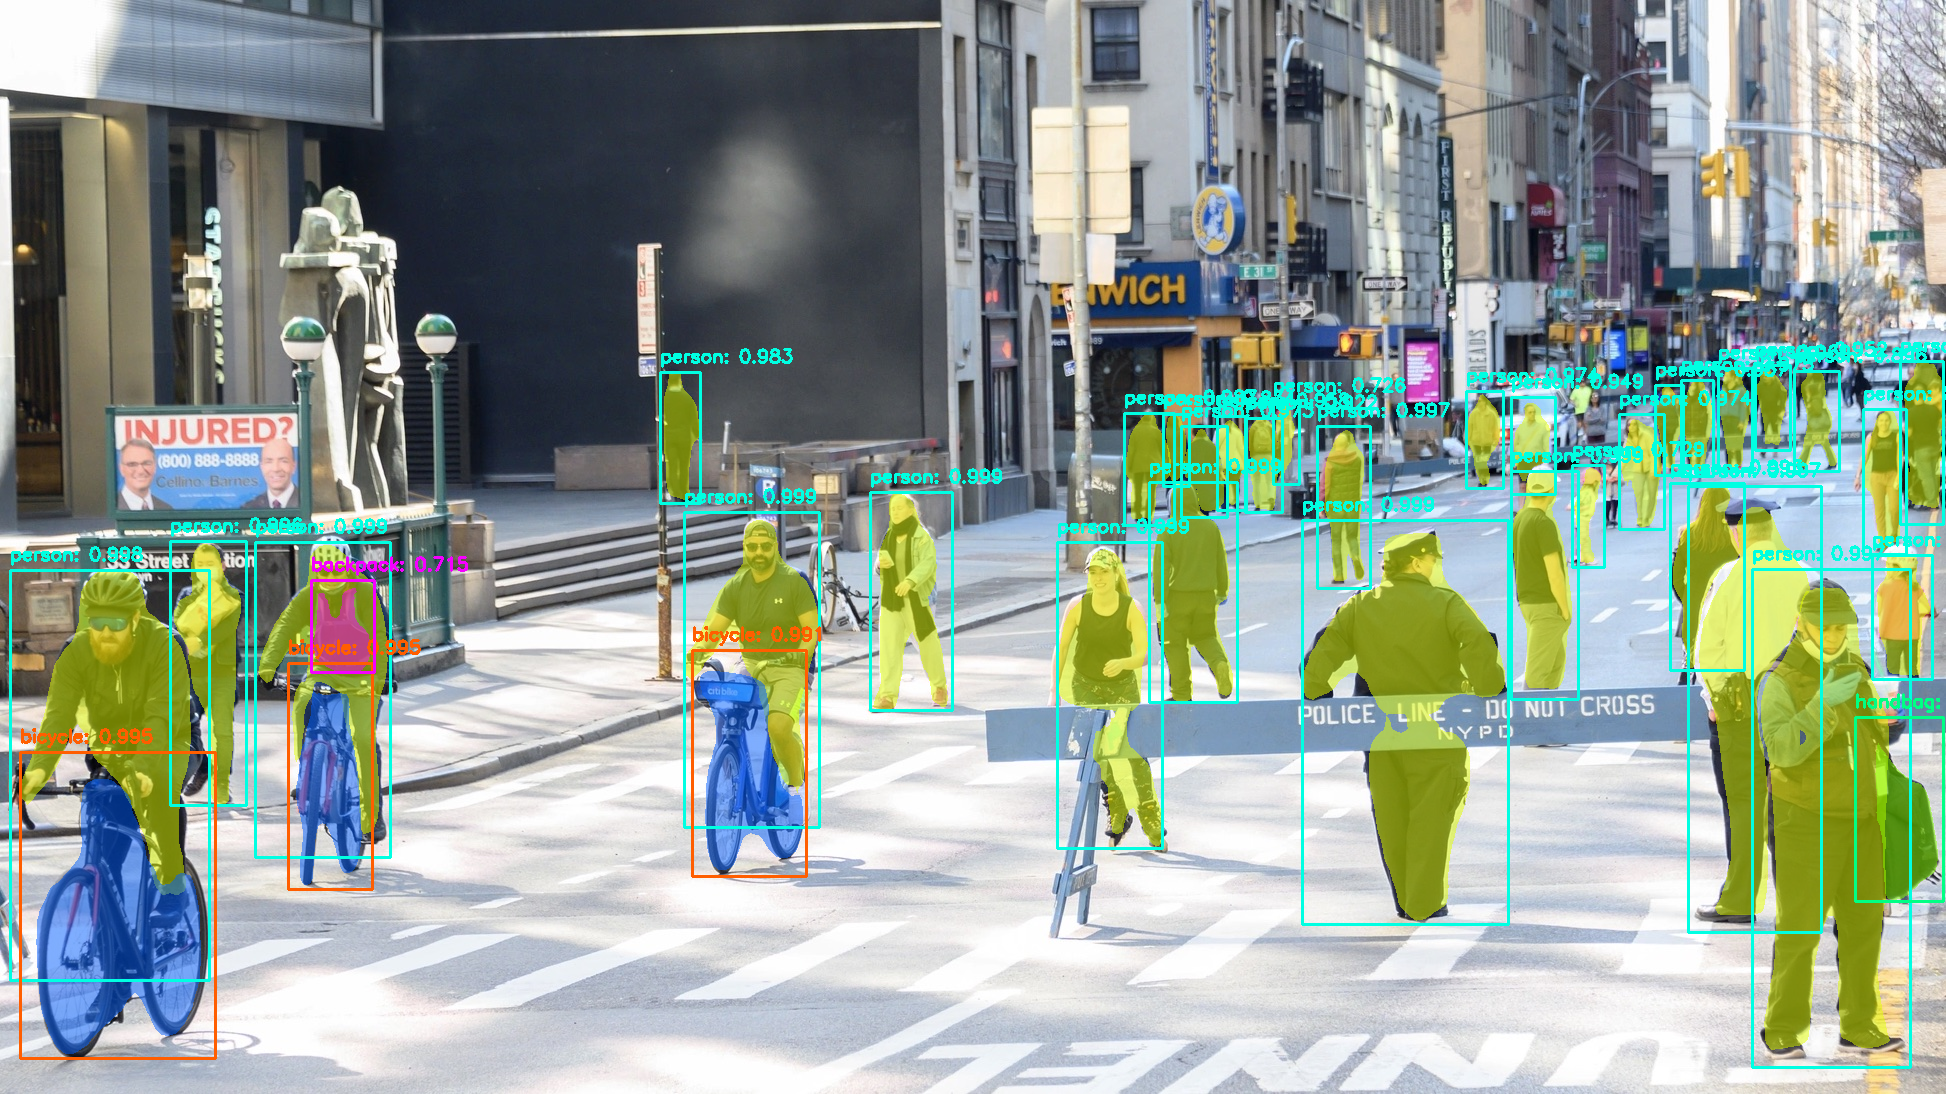

In [ ]:
# loop through the predicted scores
for i in range(0, len(r["scores"])):
  # get the score (predicted probability)
  score = r["scores"][i]
  # filter the detections based on score
  if score > score_threshold:
    # get the bounding box (bbox)
    (bbox_start_y, bbox_start_x, bbox_end_y, bbox_end_x) = r["rois"][i]
    # get the class ID
    classID = r["class_ids"][i]
    # get the label
    label = CLASS_NAMES[classID]
    # get the class color
    color = [int(c) for c in np.array(CLASS_COLORS[classID]) * 255]
    # draw the bounding box
    cv2.rectangle(output, (bbox_start_x, bbox_start_y), (bbox_end_x, bbox_end_y), color, 2)
    # print the object class label and score 
    text = "{}: {:.3f}".format(label, score)
    # make sure teh starting y-coord of the text is within the image
    y = bbox_start_y - 10 if bbox_start_y - 10 > 10 else bbox_startY + 10
    cv2.putText(output, text, (bbox_start_x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
# display the result
cv2_imshow(output)

## Selective visualization

Use the function below to extract the detected object(s) from the input image.

In [ ]:
def instance_extraction(image, r):

  result = image.copy()
  result = result*0

  mask_all = result.copy()
  for i in range(0, len(r["scores"])):
    # get the score (predicted probability)
    score = r["scores"][i]
    # filter the detections based on score
    if score > score_threshold:
      # get the mask
      mask = r['masks'][:,:,i]
      # convert mask to a 3 channel image of type UCHARx3
      mask = np.stack((mask,)*3, axis=-1)
      mask = mask.astype('uint8')
      # mask the selected detections
      masked_img = image*mask
      # add the white background
      #result = masked_img + bg
      mask_all = cv2.max(mask_all, masked_img)
  # create a white background image
  # mask is binary [0,1] so to make usable multiply it by 255
  bg = 255 - mask_all*255
  result = masked_img + bg
  return result

In [ ]:
segmentation = instance_extraction(image, r)
plt.subplots(1, figsize=(16, 16))
plt.axis('off')
plt.imshow(np.concatenate([image, segmentation], axis = 1))